## Load libs

In [1]:
import numpy as np
from dataset.voc_loader import VOCLoader
from augmentation.instance_augmentor import Augmentor
from utils.utils_bbox import draw_bbox
from utils.utils_general import read_textfile, write_file

## Initialize data loader
This loader structure is capable of loading the data and annotaions from the disk, feeding the training queue with original training samples and visualizing those samples with corresponding annotations

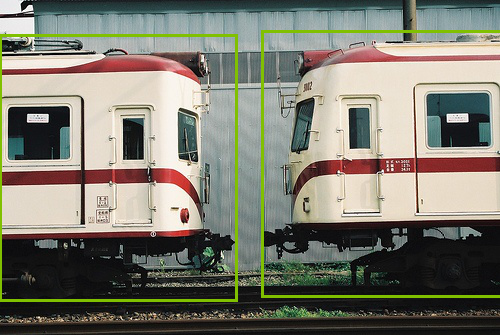

In [2]:
# initializing the loader
loader = VOCLoader('12', 'val', segmentation=True)

# picking an image
filename = loader.get_filenames()[1]
# visualizing the sample with annotations
loader.visualize(filename)

## Augmenting the loader
For this, we feed our loader instance to an augmentor. This returns an instance of an augmented loader.

We can sample training images from it, that are augmented using our context guidance.

Precise augmentation pipeline is set by the config dictionary, initializing the augmentor. Here, more on how to parametrize your augmentation pipeline.
The augmentor supports 3 types of augmentation: **enlargement**, **duplication** and **context guided pasting**.

### Enlargement
This type of augmentation takes an instance, scales it up by a random factor between `enlarge_min_scale` and `enlarge_max_scale`, and puts right back to cover the initial instance.
Set `enlarge` to `True` to use it for augmentation.

In [3]:
enlarge_config = {
    'enlarge': False,
    'enlarge_min_scale': 1.2,
    'enlarge_max_scale': 1.6,
}

### Duplication
If `duplicate` is `True`, performs copy-pasting of an instance in the scope of one image (places the copy of an object near by the original instance). If `no_spatial_constraints` is `True`, increasing the `duplicate_radius` will increase the maximum distance from the original instance to the pasted instance (pastes further away).

If `dynamic` is `True`, copies instances from other images in neighborhoods of existing instances of the same category.

In [4]:
duplicate_config = {
    'duplicate': False,
    'no_spatial_constraints': True,
    'duplicate_radius': 0.6,
    'dynamic': False,
}

### Context driven placement
This type of augmentation uses locations proposed by a trained context model to paste instances there.

To use the context-driven data augmentation, put `context_name` in correspondance with the run_name of the model you trained, and run on a dataset to be augmented. Otherwise, set it to `None`. `context_conf` sets the minimum confidence of a location (predicted by the context model) that allows the location to be used for augmentation (0.7 hits a good enough precision-recall tradeoff). Set `total_context` to `False`, if you want to augment with context only images, that don't have positive object (for example, when you create a loader and augment for only one category).

**Note**, that the context model doesn't predict the exact instance to be placed in a given location, but rather an object's category. This means that an image could look not realistic due to very different illumination or style of the scene and the instance, or due to truncated instance pasted. Nevertheless, this data augmentation type allows to improve performance of a model, trained on this images (as opposed to random placement).

In [5]:
context_config = {
    'context_name': 'voc12train_neg3',
    'context_conf': 0.7,
    'total_context': True
}

### General config
Each image is augmented with probability `aug_prob`, or left not augmented otherwise. In one image, only N objects could be pasted/augmented, where N is chosen randomly in interval between `min_objects` and `max_objects`. Before pasting an image, it could be randomly color-modified. Set `colorize` to `True` to have augment instances with color too.

In [6]:
general_config = {
    'aug_prob': 1,
    'min_objects': 1,
    'max_objects': 2,
    'colorize': False,
}

In [20]:
# Here we merge all the configs into one and initialize the augmented 
aug_config = {**enlarge_config, **duplicate_config, **context_config, **general_config}
aug_loader = Augmentor(loader, aug_config) # this may take a while

BEFORE LOAD| instance sources: 1449, pos_filenames:1449, context positive images: None
interm_context_load: len 1324, loaded from /scratch/algorab/mdvornik/Projects/Releases/context_model_pre/Data/context_mapping/voc12val_small/voc12train_neg3.npy
The context file of total len 1324 is loaded from 1 dataset(s)
Full dict was loaded from file voc12train_neg3
AFTER LOAD| instance sources: 1449, pos_filenames:1449, context positive images: 1324


# Augmentated samples

## For multiple categories

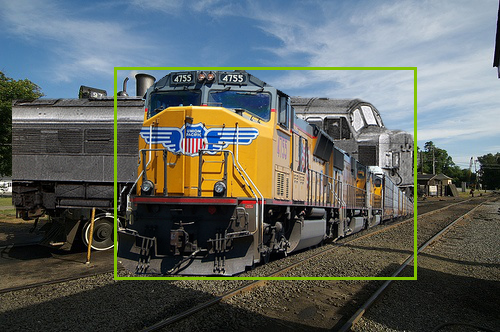

In [21]:
# Just run this cell as many times as you wish.
# Every time you'll get a new image

name = np.random.choice(loader.filenames)
aug_loader.visualize(name)

## For a single category

In [ ]:
# we need to define a single-class loader
single_loader = VOCLoader('12', 'val', True, cats_include=[5]) # this corresponds to the bottle class

# And augmenting it 
single_aug_config = {**enlarge_config, **duplicate_config, **context_config, **general_config}
single_aug_config['total_context'] = False # to augment only images, that don't have a bottle
aug_loader = Augmentor(single_loader, single_aug_config)  # this may take a while

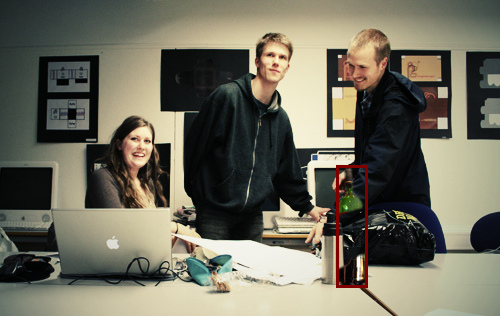

In [44]:
# Just run this cell as many times as you wish.
# Every time you'll get a new image

name = np.random.choice(aug_loader.get_filenames('context'))
aug_loader.visualize(name)